<center>
<h1>Youtube Scam Comment Classification</h1>

By David Andrés Sanchez and Juan Becerro Campos
</center>

<div>
<h2> Index </h2>
<ul> 
    <li>Introduction</li>
    <ul> 
        <li>Context</li>
        <li>Targets</li>
    </ul>
    <br>
    <li>Code Explanation </li>
    <ul>
        <li>Process</li>
        <li>Metrics</li>   
    </ul>
    <li>Conclussions</li>
</ul>
</div>


<h1> Introduction </h1>
<ul>
    <li>
    <h2> Context </h2>
    <p> The project arose from an actual problem that we identified in Social Media Platforms, especially on YouTube. Such problem is the abundance of scams in the comment section, being this section the main way to interact with the community. Scam comments are more frequent the more famous a channel is. 
    <br>
    These scams usually consists on tricking a user into thinkin they've won a price by impersonating the content creator.
    <br><br>
    Starting from this problem, we have concluded that it can be resolved by using a <b>NLP</b> application that will process all the comments, train a model and use it to identify Scam comments and Users on any given video.
    </p>
    </li>
    <li>
    <h2> Targets </h2>
    <ol>
        <li>Create a dataset with the appropiate information.</li>
        <li>Train a model given the dataset to clasify the comments and users.</li>
        <li>Use the model to create a simple application capable of showing the scam users for any given video.</li>
    </ol>
    </li>
</ul>


<h1> Code Explanation </h1> 
<ul>
<li>
    <h2> Process </h2>
    <p>
    First we have to import the necesary libraries to create our model, mainly we will need pandas for dataset management, numpy for mathematical operations, matplotlib to plot our data, re/nltk for text processing, sklearn for the Model creation itself.
    </p>
    <br>
</li>
</ul>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

import os
import json

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mrbid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mrbid\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mrbid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<ul>
<p>
We then import our initial dataset, this dataset was created by us using an API provided by Google that allow us to retrieve the commentss. The script "DatasetGeneration.py" is the one responsible for the task of creating said dataset. We have selected a video with a large amount of comments and a good sample of scams to create the dataset.
</p>
</ul>

In [5]:
Comments = []
commentsId = []
repliesCount = []
isReplies = []
Usernames = []
UserIds = []

for i in range(0, 1000):
            
    if not os.path.exists(f'hD1YtmKXNb4/{i}.json'): 
        break

    with open(f'hD1YtmKXNb4/{i}.json', 'r') as openfile:
        # Reading from json file
        response = json.load(openfile)

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_id = item['snippet']['topLevelComment']['id']
            reply_count = item['snippet']['totalReplyCount']
            isReply = False
            authorName = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            
            if 'authorChannelId' in item['snippet']['topLevelComment']['snippet']:
                authorId =  item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
            else:
                authorId = None

            #append to lists
            Comments.append(comment)
            commentsId.append(comment_id)
            repliesCount.append(reply_count)
            isReplies.append(isReply)
            Usernames.append(authorName)
            UserIds.append(authorId)

            if reply_count > 0 and 'replies' in item:
                for reply in item['replies']['comments']:
                    reply_comment = reply['snippet']['textDisplay']
                    reply_comment_id = reply['id']
                    reply_reply_count = 0
                    isReply = True
                    reply_author_name = reply['snippet']['authorDisplayName']
                    if 'authorChannelId' in reply['snippet']:
                        reply_author_id = reply['snippet']['authorChannelId']['value']
                    else:
                        reply_author_id = None

                    #append to lists
                    Comments.append(reply_comment)
                    commentsId.append(reply_comment_id)
                    repliesCount.append(reply_reply_count)
                    isReplies.append(isReply)
                    Usernames.append(reply_author_name)
                    UserIds.append(reply_author_id)

zipped = list(zip(Comments, commentsId, repliesCount, isReplies, Usernames, UserIds))

data = pd.DataFrame(zipped, columns=["Comments", "Comment ID", "Reply Count", "Is Reply", "Author", "AuthorID"])
#data = pd.read_csv('comments.csv', sep=',', header=0)


<ul><li>
<h2> The Dataset</h2>
<p>
The dataset, as shown below, is composed of six columns and 109585 rows. The first column is the comment itself without any text processing, then the Comment ID, the number of replies, the Author of the comment, and finally the user ID.

The dataset itself is not classified, so we had to manually classify the comments manually. This sounds like a very tedious task, but thanks to the nature of the problem, and the data avaliable, we can create a list of known scam comment users and automatically classify all comments this user has on the dataset; this is very effective because a scam comment user tends to post several comments.
</p>
</li></ul>


In [6]:
data.head()

,Comments,Comment ID,Reply Count,Is Reply,Author,AuthorID
0,I hope you guys like the new video concept :),UgzXpQ-MqCv9qFrJX-J4AaABAg,384,False,MrBeast,UCX6OQ3DkcsbYNE6H8uQQuVA
1,your mom,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_r9Qou0luY,0,True,ry kb,UCsstKyC1CPj3wreooY4hOTQ
2,Y r best,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_f1uKkX_rM,0,True,Debashis Bhattacharjee,UCf-dsJptn7VzK4C8jbMljLw
3,Last,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRcKc106,0,True,Niloy Zaman,UCtK2uwqQwCElqNN067Iod4w
4,I love you,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRQSSdEj,0,True,RedTune605,UCFlNRv9FlLyypfrvBTQkjTw


In [7]:
scamChannels = ['UCwgMHGG8IDcYjjSXtYbE9rQ', 'UC8Oy99fOvCjHfbvTImDXpkg',
'UCswOElw6g7pEeAA5Mu15p3Q', 'UCIknJ8HTOMLSfIAmtsm84vA', 'UCsXIMkerN0ofYQVIvNWr7Dg', 'UC5iFMKp-Tuf2RX8wTDIA00w',
'UC4BTXtDeOzz85XMShFWY1VA', 'UCIIab0_13sTLxQY66QjpM-g', 'UCZIIrgNdsq0MPdbG6utOLmw', 'UCf3mY9fz0oesuFS4fUnhjsg',
'UCii92DZYgGqYquT71D9cWSQ', 'UCSkoxrUobYERf5FI1F0KDTg', 'UCbdM2ysSVcPxHghp50tiPQw', 'UC1Wi-CaZ_u111EET3es-jzA',
'UCJB7ZvEbo-xRZum_3Zmq9sw', 'UCe5DcGeti6adyFedf49MRuA', 'UCfOYoX3Cwcn0A8t32c3cM5g', 'UCIAYvaVP15Cel4NZ1ib_ADA',
'UCgvlSYolCHq5JiiosIvM6lw', 'UCcxxhVKa9wVvHXscwMXC2gQ', 'UCs5NZ-lIbR_rvYDaKvBrVFw', 'UCMhUkjPmAi9xrbskMrdNPWA',
'UCHCtAgNRSrcBMRqU5SfHplw', 'UC07gLBHCOrcOyE0bw8Lv8Jg', 'UCnOW6JnwbE46hKOPyDYxc_w', 'UCLlW4UJkWDqW9Ht4u8LRztw',
'UCoPBjpeflrKudIDsvDEV0aw', 'UCcoKvgQgWLXosFP5giUeI4g', 'UChYGnlCGDagZT0F8GYhDY2w', 'UCapA77PmpW9dEZQxxJY7TIg',
'UCfdoVOJ9krvIZReKoLWAelA', 'UCU5WWthBfCSYPt-YRNRZYPQ', 'UCDDbjiG_3PHqn4_8BRMr9yA', 'UCVnjpK8HoaeYGQCJUjtiq6g',
'UCkJePyY8lKMvWSF9S-X_hpQ', 'UCwRfjTiJGrONLlNHFQ0mQ2A', 'UCJoDuLaZaOmmTLk9IVst6OA', 'UCk4bBXoqPm8j2FjyStas7jQ',
'UC6M_UOk3D8ZG0J2HmuK6J7g', 'UCgHM7Mjvat503rAX9jlFf3w', 'UCzywEh2M-ReJTvlPh-jA1-w', 'UClmn1s3aSJcqsGoQG7ZV5rg',
'UClmXrUcfU0A3BWSCU1XouNg', 'UCDhBrg4uKxdc0u5mv2x9GAA', 'UC4A5Ov8NNZ8K1Lq5cfcESUg', 'UC7qpkq26VEDSe6H3ZwTMWJg',
'UCk44Jx55IZkD57On49NFtiw', 'UCPDuYbsUJxNexaCBruG-jkw', 'UCOqxwnL0H8oCTHlBNO9uSGQ', 'UCblmGPQJ1_O_gBMmGRiVM9Q',
'UC4IerKEP2BDFd2VVXLaeU7w', 'UChoTld7IoAinX5E7nYTZJVg', 'UCYbUqEvxVhVh71wBbrgvyGA', 'UCEmzN-PVaElRDmdlBFbMW1A',
'UCNBOZg8v0cFe2RYvSgJ_K3A', 'UCpTKksadLBwHiFOdtxVq5Sg', 'UCkGvXvq42A152M8S5xOMbBw', 'UC4kPR2QLYHmURMMr5ERPAcA',
'UCJ4a59zmaTKVThYBU-ZZdFA', 'UCV_Qh1S9gCCXm2XBQRy0v8Q', 'UCgP6tTK8LrlhK7LMhExs6eQ', 'UCRqHZqWr81nXW0Qr2MVcD-g',
'UCfH5_gBNYMszkN-6P1SAC1Q', 'UCYGbbdOfUAtBOFoiifA4cpw', 'UCFSHMdKANs7Ee_xAfvfX7ug', 'UChYuxekYJM1HXY6ThthPR8A',
'UCXLbuE7gWN6CVyliQHKP62w', 'UCpd3kplR9EdsvjbCAtp1JPw', 'UCOLzBAcpeCiue5PnlPSvczQ', 'UC0anupzl59WSN3XiwtcskaA',
'UClLJBDGFBNEvfuqO7mnISDA', 'UCINx9NBUBTrtejzu6j_Msrw', 'UCnoWpxUsITYEz7PN5gUnjig', 'UCFRi7Mrj-Eg4QWDo4hklyNQ',
'UCjq5OmDN3GpsEJnC7IN2wrw', 'UC-qClLgMIxMzxutSFCX3Z7Q', 'UCf4yPu2n776Y4UNyOrgBGyw', 'UCKXxgBp0ayWv9ltjB7JdjSw',
'UCuftC8pB9Qkp7NgfDDTWogQ', 'UCrdtt67J70SGqUbmpzsZB7A', 'UC0ALSPkH0CWGHWQnjKqUcZA', 'UChDOklT_Llw8Fhe73S_V9uA',
'UCXKK2TaXBVTFLoVThFZ7xjw', 'UC4Az0jfOzfLEye0hFMVddpw', 'UC4paLTpfQMaGw3fGTVhhgDg', 'UCPuAuTprV61plFTD7a6Xb2w',
'UCZMhE9u0wSQhRiEfca5q8Gg', 'UCG5f10-PAcrTQzofSen_reA'
]

def isScam(id):

    if  id in scamChannels:
        return 1
    else:
        return 0


data['Is Scam'] = data['AuthorID'].apply(lambda x: isScam(x))
data.head()

,Comments,Comment ID,Reply Count,Is Reply,Author,AuthorID,Is Scam
0,I hope you guys like the new video concept :),UgzXpQ-MqCv9qFrJX-J4AaABAg,384,False,MrBeast,UCX6OQ3DkcsbYNE6H8uQQuVA,0
1,your mom,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_r9Qou0luY,0,True,ry kb,UCsstKyC1CPj3wreooY4hOTQ,0
2,Y r best,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_f1uKkX_rM,0,True,Debashis Bhattacharjee,UCf-dsJptn7VzK4C8jbMljLw,0
3,Last,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRcKc106,0,True,Niloy Zaman,UCtK2uwqQwCElqNN067Iod4w,0
4,I love you,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRQSSdEj,0,True,RedTune605,UCFlNRv9FlLyypfrvBTQkjTw,0


<ul>
Now we will separate our dataset in two parts, the first one will contain the first 30000 rows, and will be our training data, and our second one, that will contain the next 5000 rows will be our test dataset.
</ul>

In [8]:
train = data[0:30000].copy()[['Comments', 'Is Reply', 'Author', 'Is Scam']]
test = data[30001:35001].copy()[['Comments', 'Is Reply', 'Author', 'AuthorID']]

<ul>
We can see how many scam comments we classified from our training data.
</ul>

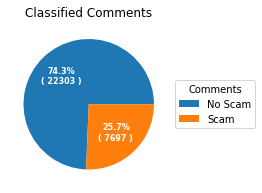

In [9]:
#plot
x = train['Is Scam'].value_counts()

def label(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n( {:d} )".format(pct, absolute)

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(x, autopct=lambda pct:label(pct, x), textprops=dict(color="w"))
ax.legend(wedges, ["No Scam", "Scam"], title="Comments", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Classified Comments")
plt.setp(autotexts, size=8, weight="bold")
plt.show()

<ul>
<p>
Next we need to process our Comments and Usernames, to do this, we will convert to lowercase, strip and remove punctuations from each comment, and then we will use nltk to lemmatize and tokenize the text. This way, our text will be processed and ready to vectorize it so it can be used by a ML model.
</p>
</ul>

In [10]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = str(text).lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))


train['Clean Comment'] = train['Comments'].apply(lambda x: finalpreprocess(x))
train['Clean Author'] = train['Author'].apply(lambda x: finalpreprocess(x))
train['Clean text tokens']=[nltk.word_tokenize(i) for i in train['Clean Comment']]
train['Clean Author tokens']=[nltk.word_tokenize(i) for i in train['Clean Author']]


<ul>
<p>
We can see how now in the columns 'Clean text Tokens' and 'Clean Author tokens' we have lists of word tokens instead of the preprocessed text we can read in the column 'Comments' or 'Author'.
</p>
</ul>

In [11]:
train.head()

,Comments,Is Reply,Author,Is Scam,Clean Comment,Clean Author,Clean text tokens,Clean Author tokens
0,I hope you guys like the new video concept :),False,MrBeast,0,hope guy like new video concept,mrbeast,"[hope, guy, like, new, video, concept]",[mrbeast]
1,your mom,True,ry kb,0,mom,ry kb,[mom],"[ry, kb]"
2,Y r best,True,Debashis Bhattacharjee,0,r best,debashis bhattacharjee,"[r, best]","[debashis, bhattacharjee]"
3,Last,True,Niloy Zaman,0,last,niloy zaman,[last],"[niloy, zaman]"
4,I love you,True,RedTune605,0,love,redtune,[love],[redtune]


<ul>
<p>
Now we will sepparate our training data into four dataframes X_train, X_test, y_train, y_test. From this we will take four of them to create a dataset, responsible of clasifying the comments as scam according to the usernames, and other one that will solely clasify them by the comment text itself.
</p>
</ul>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train['Clean Comment'], train['Is Scam'], test_size=0.4, shuffle=True)
X_train_author, X_test_author, y_train_author, y_test_author = train_test_split(train['Clean Author'], train['Is Scam'], test_size=0.4, shuffle=True)

<ul>
<p>
We create a Tf-idf vectorizer with our processed text.
</p>
</ul>

In [13]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=10)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer')

author_tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=5)
X_train_vectors_tfidf_author = author_tfidf_vectorizer.fit_transform(X_train_author) 
X_test_vectors_tfidf_author = author_tfidf_vectorizer.transform(X_test_author)
joblib.dump(author_tfidf_vectorizer, 'author_tfidf_vectorizer')


['author_tfidf_vectorizer']

<ul>
<p>
In order to visualize the tf-idf results, here we can see how are the top 50 features for the comments are ordered by label. (1 = scam, 0 = no scam)
</p>
</ul>

c:\Users\Mrbid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


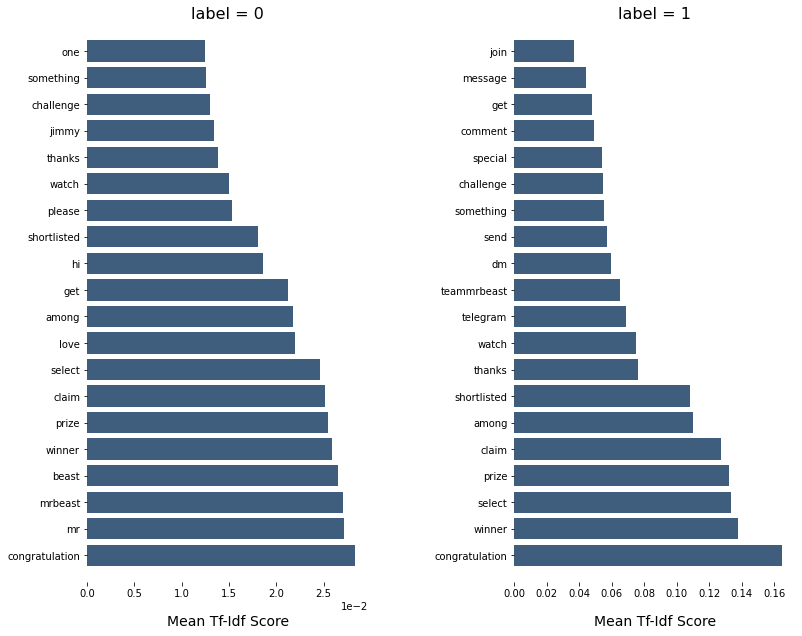

c:\Users\Mrbid\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Mrbid\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9450 missing from current font.
  font.set_text(s, 0, flags=flags)


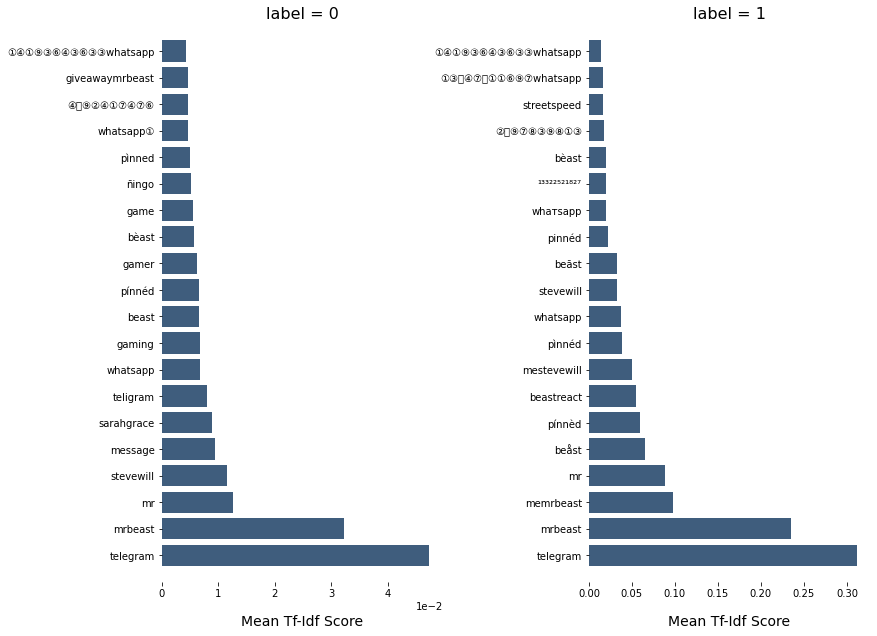

In [14]:
comments_features = tfidf_vectorizer.get_feature_names()
author_features = author_tfidf_vectorizer.get_feature_names()

def top_tfidf_feats(row, features, top_n = 25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)

plot_tfidf_classfeats_h(top_feats_by_class(X_train_vectors_tfidf, y_train, comments_features, top_n=20))
plt.show()
plot_tfidf_classfeats_h(top_feats_by_class(X_train_vectors_tfidf_author, y_train_author, author_features, top_n=20))
plt.show()


<ul>
<p>
Now that we have the vectorized data, we can use it to train our models, after comparing results with different model types, the more promissing was Logistic Regression.
</p>
</ul>

In [25]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model


#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf_author=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf_author.fit(X_train_vectors_tfidf_author, y_train_author)  #model

joblib.dump(lr_tfidf, 'CommentTextModel')
joblib.dump(lr_tfidf_author, 'AuthorNameModel')


['CommentTextModel']

<ul>
<h2> Metrics </h2>
We will now focus a litlle more in the results of each model
<br> 
After execution, these are the results obtained by the model that classifies acording to the comment text.
</ul>

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9012
           1       0.75      0.94      0.83      2988

    accuracy                           0.91     12000
   macro avg       0.86      0.92      0.88     12000
weighted avg       0.92      0.91      0.91     12000

Confusion Matrix:
 [[8057  955]
 [ 182 2806]]
AUC: 0.9573154840103124


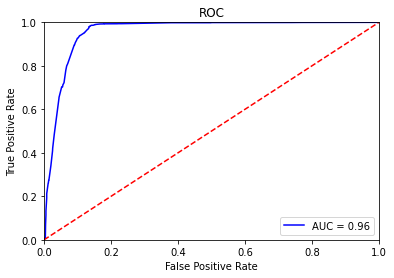

In [26]:

y_predict1 = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob1 = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]


fpr, tpr, thresholds = roc_curve(y_test, y_prob1)
roc_auc = auc(fpr, tpr)

print(classification_report(y_test,y_predict1))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict1))
print('AUC:', roc_auc)

#plot
plt.title("ROC")
plt.plot(fpr, tpr, 'b', label= 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<ul>
As we can see, we were able to obtain a highly accurate model.
<br>
New we will show the results obtained by the model that classifies acording to the username.
</ul>

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      8943
           1       0.85      0.93      0.89      3057

    accuracy                           0.94     12000
   macro avg       0.91      0.94      0.93     12000
weighted avg       0.95      0.94      0.94     12000

Confusion Matrix:
 [[8450  493]
 [ 200 2857]]
AUC: 0.9846528650851679


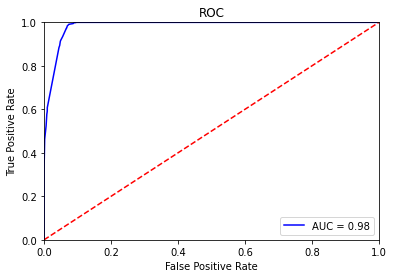

In [27]:

y_predict = lr_tfidf_author.predict(X_test_vectors_tfidf_author)
y_prob = lr_tfidf_author.predict_proba(X_test_vectors_tfidf_author)[:,1]

print(classification_report(y_test_author,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test_author, y_predict))

fpr, tpr, thresholds = roc_curve(y_test_author, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)


#plot
plt.title("ROC")
plt.plot(fpr, tpr, 'b', label= 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<ul>
Once more we have obtained a high accuracy value for this model.
<br>
Lastly we create a new dataset from comments the model has never seen and give it the task to clasify them. This is how it performs.
</ul>

In [17]:
#Pre-processing the new dataset
test['Clean Comments'] = test['Comments'].apply(lambda x: finalpreprocess(x)) #preprocess the data
test['Clean Author'] = test['Author'].apply(lambda x: finalpreprocess(x))

X_test = test['Clean Comments']
X_test_author = test['Clean Author']

#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)
X_vector_author = author_tfidf_vectorizer.transform(X_test_author)

#use the best model to predict 'target' value for the new dataset 
lr_tfidf = joblib.load('CommentTextModel')
lr_tfidf_author = joblib.load('AuthorNameModel')

y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]

y_predict_author = lr_tfidf_author.predict(X_vector_author)
y_prob_author = lr_tfidf_author.predict_proba(X_vector_author)[:,1]

test['predict_prob']= y_prob
test['Is Scam']= y_predict
test['author_predict_prob'] = y_prob_author
test['Is Scam byAuthor'] = y_predict_author
final=test[['Clean Comments', 'Clean Author', 'predict_prob', 'author_predict_prob', 'Is Scam', 'Is Scam byAuthor', 'AuthorID']].reset_index(drop=True)

In [18]:
final[final['Is Scam'] == True]

,Clean Comments,Clean Author,predict_prob,author_predict_prob,Is Scam,Is Scam byAuthor,AuthorID
38,get something special,telegram mrbeast,0.631597,0.750374,1,1,UCJ3B5UCBGb5TBg91wuvewZQ
39,woww read profile picture,,0.502565,0.001962,1,0,UCa4SZGPlHL5AYIscbTqXdDQ
120,thanks watch leave comment telegram claim prize,telegram mrbeast,0.676617,0.750374,1,1,UC93veh5Su4UfpSW5npM1NUg
139,thanks watch leave comment telegram claim prize,telegram mrbeast,0.676617,0.750374,1,1,UC93veh5Su4UfpSW5npM1NUg
141,thanks watch leave comment telegram claim prize,telegram mrbeast,0.676617,0.750374,1,1,UC93veh5Su4UfpSW5npM1NUg
...,...,...,...,...,...,...,...
4990,get something special,telegram mestevewill,0.631597,0.865076,1,1,UC4Az0jfOzfLEye0hFMVddpw
4991,congratulation select among shortlisted winner,telegram memrbeast,0.757994,0.960325,1,1,UCYGbbdOfUAtBOFoiifA4cpw
4993,congratulation select among shortlisted winner,telegram memrbeast,0.757994,0.960325,1,1,UCYGbbdOfUAtBOFoiifA4cpw
4996,get something special,telegram mestevewill,0.631597,0.865076,1,1,UC4Az0jfOzfLEye0hFMVddpw



<h1> Conclusions </h1>
Once developed the model and made a test execution we can appreciate how, thanks to its accuracy, it has the potential to be a useful tool to avoid scams in sites that are accesible for everybody. We were happy to see how it worked as a proof of concept.